In [7]:
# !curl -L -o ../data/chest-xray-pneumonia.zip https://www.kaggle.com/api/v1/datasets/download/paultimothymooney/chest-xray-pneumonia

# !unzip ../data/chest-xray-pneumonia.zip -d ../data/
!rm -R ../data/chest_xray//chest_xray/

rm: ../data/chest_xray//chest_xray/: No such file or directory


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

plt.style.use('dark_background')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color = sns.color_palette('dark'))

## Load and Visualize data:


In [2]:
trainImages = tf.keras.utils.image_dataset_from_directory('../../data/vision/chest_xray/train')
trainImages.cardinality().numpy() * 32

Found 5216 files belonging to 2 classes.


2025-12-29 11:40:23.201686: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-12-29 11:40:23.201716: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-12-29 11:40:23.201720: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-12-29 11:40:23.201742: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-29 11:40:23.201752: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


5216

In [3]:
#load dataset from cell in tfrecord format:
trainImages = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec"
)
trainPaths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec"
)



traindataset = tf.data.Dataset.zip((trainImages , trainPaths))

2025-12-29 11:40:23.588396: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


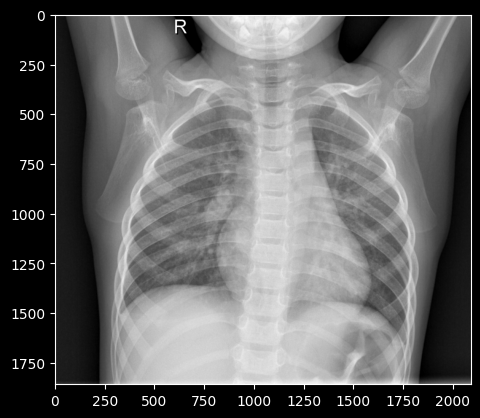

In [4]:
raw_img , raw_label = next(iter(traindataset))
# print(raw_label)
rimage = tf.image.decode_jpeg(raw_img , channels = 3)
# plt.imshow(tf.image.resize(rimage , (224 , 224))/225)
plt.imshow(rimage/255)

In [5]:
#craete (image , label) pair, the ones you get by default from tf.keras.utils.image_dataset_from_directory()

# for x , y in traindataset.take(1):
#     print(y.numpy().decode('utf-8'))

def get_label(filepath):
    parts = tf.strings.split(filepath , '/')
    return parts[-2] == 'PNEUMONIA'

def decode_image(image):
    image = tf.image.decode_jpeg(image , channels = 3)
    return tf.image.resize(image , (224 , 224))

def processdata(image , filepath):
    label = int(get_label(filepath))
    # print(label)
    image = decode_image(image)
    return (image , label)

traindataset = traindataset.map(processdata , num_parallel_calls= tf.data.AUTOTUNE)

In [6]:
# dataset test:
timage = next(iter(trainImages))
tpath = next(iter(trainPaths))
processdata(timage , tpath)

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[ 23.647322,  23.647322,  23.647322],
         [ 19.816309,  19.816309,  19.816309],
         [ 19.18194 ,  19.18194 ,  19.18194 ],
         ...,
         [ 94.11284 ,  94.11284 ,  94.11284 ],
         [ 93.32666 ,  93.32666 ,  93.32666 ],
         [ 94.81236 ,  94.81236 ,  94.81236 ]],
 
        [[ 22.174765,  22.174765,  22.174765],
         [ 21.504463,  21.504463,  21.504463],
         [ 17.348213,  17.348213,  17.348213],
         ...,
         [ 90.873604,  90.873604,  90.873604],
         [ 93.95124 ,  93.95124 ,  93.95124 ],
         [ 94.009575,  94.009575,  94.009575]],
 
        [[ 24.039082,  24.039082,  24.039082],
         [ 20.      ,  20.      ,  20.      ],
         [ 18.958805,  18.958805,  18.958805],
         ...,
         [ 92.502754,  92.502754,  92.502754],
         [ 92.62184 ,  92.62184 ,  92.62184 ],
         [ 91.40164 ,  91.40164 ,  91.40164 ]],
 
        ...,
 
        [[ 28.795725,  28.795725

In [7]:
cnormal = len([path for path in trainPaths if 'NORMAL' in path.numpy().decode('utf-8')])
cabnormal = len([path for path in trainPaths if 'PNEUMONIA' in path.numpy().decode('utf-8')])

print(f"Normal Images: {cnormal} , Pneumonia Images: {cabnormal} , total images in training set: {cnormal + cabnormal}")

2025-12-29 11:40:41.890152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Normal Images: 1349 , Pneumonia Images: 3883 , total images in training set: 5232


2025-12-29 11:40:43.785634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
# calculate imbalanced class weights:
# 0 -> normal
# 1 -> pneumonia
ctotal = cnormal + cabnormal
w0 = (ctotal / (2 * cnormal))
w1 = (ctotal / (2 * cabnormal))
w0 , w1
class_weight = {0: w0, 1: w1}
class_weight

{0: 1.939214232765011, 1: 0.6737058975019315}

In [9]:
#same thing for testdata:
testImages = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
testpaths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)

testdataset = tf.data.Dataset.zip((testImages , testpaths))
testdataset = testdataset.map(processdata , num_parallel_calls= tf.data.AUTOTUNE)
# #tuning for better training:
traindataset = traindataset.shuffle(traindataset.cardinality()).batch(32 * 8).prefetch(tf.data.AUTOTUNE)
testdataset = testdataset.shuffle(testdataset.cardinality()).batch(32 * 8).prefetch(tf.data.AUTOTUNE)

In [10]:
trainit = iter(traindataset)

In [11]:
x , y = next(trainit)
print(f"{x.shape} , {y.shape}")

2025-12-29 11:40:54.299836: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 1 of -2
2025-12-29 11:41:07.739453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 236 of -2
2025-12-29 11:41:27.998059: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 567 of -2
2025-12-29 11:41:48.860560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 889 of -2
2025-12-29 11:42:09.028313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 1202 of -2
2025-12-29 11:42:27.766629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 256

(256, 224, 224, 3) , (256,)


2025-12-29 11:42:45.949859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 5022 of -2
2025-12-29 11:42:46.027645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


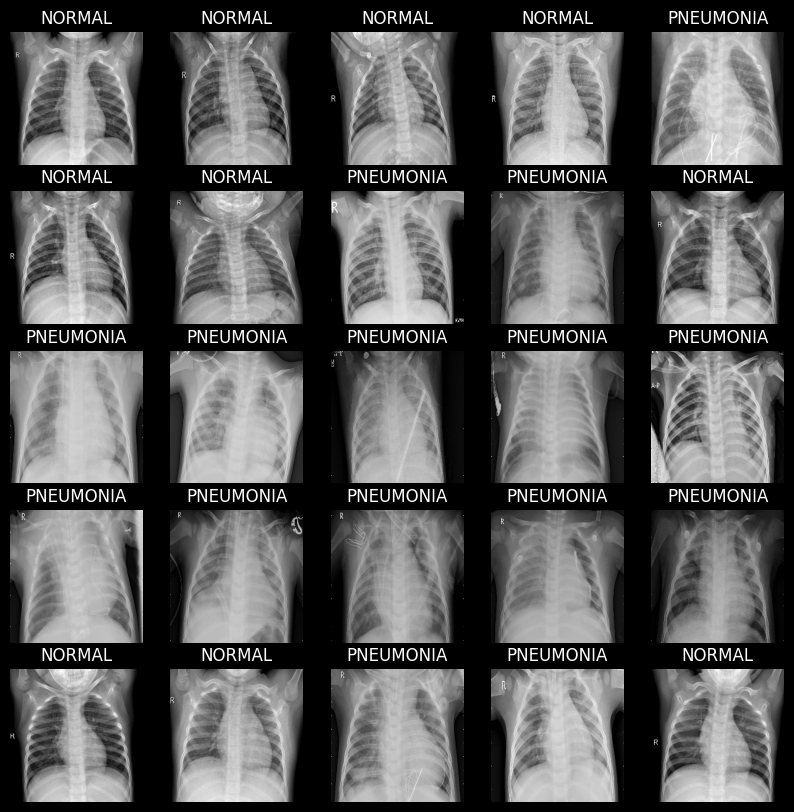

In [12]:
#visualize traindataset:
def show_batch(ibatch , lbatch):
    plt.figure(figsize = (10 , 10))
    for i in range(25):
        plt.subplot(5 , 5, i + 1)
        plt.imshow(ibatch[i] / 255)
        plt.axis('off')
        if lbatch[i]:plt.title('PNEUMONIA')
        else: plt.title('NORMAL')

ibatch , lbatch = next(trainit)
show_batch(ibatch.numpy() , lbatch.numpy())

In [13]:
ds = tf.data.Dataset.range(10)
ds = ds.shuffle(ds.cardinality()).batch(4)
for x in ds:
    print(x)
ds.cardinality()

tf.Tensor([5 6 0 2], shape=(4,), dtype=int64)
tf.Tensor([4 1 8 7], shape=(4,), dtype=int64)
tf.Tensor([3 9], shape=(2,), dtype=int64)


2025-12-29 11:42:46.578810: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<tf.Tensor: shape=(), dtype=int64, numpy=3>

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [15]:
def mobile_block(x , filters , strides):
    x = keras.layers.DepthwiseConv2D(kernel_size = 3 , strides = strides , padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters = filters , kernel_size = 1  , strides = 1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    return x

In [16]:
#stem of model:
input = layers.Input(shape = (224 , 224 , 3))
x = layers.Conv2D(filters = 32 , kernel_size = 3 , strides = 2 , padding = 'same')(input)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

In [17]:
#main part of the model:
x = mobile_block(x , filters = 64 , strides = 1)
x = mobile_block(x , filters = 128 , strides = 2)
x = mobile_block(x , filters = 128 , strides = 1)
x = mobile_block(x , filters = 256 , strides = 2)
x = mobile_block(x , filters = 256 , strides = 1)
x = mobile_block(x , filters = 512 , strides = 2)

for _ in range(5):
    x = mobile_block(x , filters = 512 , strides = 1)

x = mobile_block(x , filters = 1024 , strides = 2)
x = mobile_block(x , filters = 1024 , strides = 1)
x = layers.AvgPool2D(pool_size= 7 , strides = 1 , data_format = 'channels_first')(x)
output = layers.Dense(units = 1000 , activation = 'softmax')(x)
model = keras.models.Model(inputs = input , outputs = output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 112, 112, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 112, 112, 32)   │           320 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 56, 56, 64)     │           640 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_2              │ (None, 56, 56, 128)    │         1,280 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,258,808 (16.25 MB)

 Trainable params: 4,236,920 (16.16 MB)

 Non-trainable params: 21,888 (85.50 KB)

## using a pre-trained model:


In [18]:
def build_model():
    mobilenet_model = tf.keras.applications.MobileNetV2(
        weights = 'imagenet',
        include_top = False,
        input_shape = (224 , 224 , 3)
    )

    # freeze the pre-trained mobile-net layers except the last layer: 
    for layer in mobilenet_model.layers[:-2]:
        layer.trainable = False


    # output of the base model:

    x = mobilenet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128 , activation = 'relu')(x)
    x = tf.keras.layers.Dense(1 , activation = 'sigmoid')(x)
    model = tf.keras.Model(inputs = mobilenet_model.input , outputs = x , name = 'mobile-net_fine-tuned')

    return model

fmodel = build_model()
fmodel.summary()


Model: "mobile-net_fine-tuned"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 166,657 (651.00 KB)

 Non-trainable params: 2,255,424 (8.60 MB)

In [ ]:
#define callbacks:

checkp = tf.keras.callbacks.ModelCheckpoint('./models/xray_model.h5' , save_best_only= True)
estop = tf.keras.callbacks.EarlyStopping(patience = 3 , restore_best_weights= True)
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
initial_learning_rate = 0.01

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [20]:
finetuned_mobilenet = build_model()
METRICS = [
tf.keras.metrics.BinaryAccuracy(),
tf.keras.metrics.Precision(name="precision"),
tf.keras.metrics.Recall(name="recall"),
]

finetuned_mobilenet.compile(
optimizer=tf.keras.optimizers.Adam(),
loss="binary_crossentropy",
metrics=METRICS,
)

history = finetuned_mobilenet.fit(
traindataset,
epochs = 10,
validation_data = testdataset,
class_weight = class_weight,
callbacks=[checkp , estop , lr_scheduler]
)

Epoch 1/10


2025-12-29 11:42:49.291904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-12-29 11:43:05.092102: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 119 of -2
2025-12-29 11:43:24.833480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 455 of -2
2025-12-29 11:43:45.109110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 776 of -2
2025-12-29 11:44:05.752730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 1092 of -2
2025-12-29 11:44:25.125877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 1926 of -2
202

     21/Unknown 125s 225ms/step - binary_accuracy: 0.6331 - loss: 8.9409 - precision: 0.8133 - recall: 0.6615

2025-12-29 11:44:53.772472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-29 11:44:53.772488: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15138407337261142270
2025-12-29 11:44:53.772514: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13641234693826274290
2025-12-29 11:44:53.772523: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2674086398346603752
2025-12-29 11:44:53.772524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_18]]
2025-12-29 11:44:53.772537: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14245719130107617691
2025-12

21/21 ━━━━━━━━━━━━━━━━━━━━ 139s 895ms/step - binary_accuracy: 0.6350 - loss: 8.7910 - precision: 0.8151 - recall: 0.6622 - val_binary_accuracy: 0.7147 - val_loss: 1.7411 - val_precision: 0.7246 - val_recall: 0.8769 - learning_rate: 0.0100
Epoch 2/10


2025-12-29 11:45:22.435323: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 119 of -2
2025-12-29 11:45:42.371849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 455 of -2
2025-12-29 11:46:01.898023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 776 of -2
2025-12-29 11:46:26.971225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 990 of -2
2025-12-29 11:46:40.201939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 1202 of -2
2025-12-29 11:46:54.821307: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 1

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - binary_accuracy: 0.8758 - loss: 1.2565 - precision: 0.9316 - recall: 0.8997

2025-12-29 11:47:30.495163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-29 11:47:30.495181: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15138407337261142270
2025-12-29 11:47:30.495186: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13641234693826274290
2025-12-29 11:47:30.495190: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2674086398346603752
2025-12-29 11:47:30.495194: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16428999628071683738
2025-12-29 11:47:30.495213: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14245719130107617691
2025-12-29 11:47:30.495223: I tensorflow/core/framework/local_rende

21/21 ━━━━━━━━━━━━━━━━━━━━ 155s 803ms/step - binary_accuracy: 0.8759 - loss: 1.2514 - precision: 0.9320 - recall: 0.8993 - val_binary_accuracy: 0.7228 - val_loss: 1.6380 - val_precision: 0.7313 - val_recall: 0.8795 - learning_rate: 0.0089
Epoch 3/10


2025-12-29 11:47:57.243017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 119 of -2
2025-12-29 11:48:17.583860: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 455 of -2
2025-12-29 11:48:37.889602: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 776 of -2
2025-12-29 11:48:59.381879: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 990 of -2
2025-12-29 11:49:14.502375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 1202 of -2
2025-12-29 11:49:27.957628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 1

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - binary_accuracy: 0.8901 - loss: 0.8576 - precision: 0.9693 - recall: 0.8804

2025-12-29 11:50:04.496859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-29 11:50:04.496881: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15138407337261142270
2025-12-29 11:50:04.496887: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13641234693826274290
2025-12-29 11:50:04.496892: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2674086398346603752
2025-12-29 11:50:04.496896: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16428999628071683738
2025-12-29 11:50:04.496901: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14245719130107617691
2025-12-29 11:50:04.496903: W tensorflow/core/framework/local_rende

21/21 ━━━━━━━━━━━━━━━━━━━━ 154s 775ms/step - binary_accuracy: 0.8903 - loss: 0.8539 - precision: 0.9691 - recall: 0.8807 - val_binary_accuracy: 0.7468 - val_loss: 1.2620 - val_precision: 0.7555 - val_recall: 0.8795 - learning_rate: 0.0079
Epoch 4/10


2025-12-29 11:50:30.688344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 119 of -2
2025-12-29 11:50:50.769361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 455 of -2
2025-12-29 11:51:18.959731: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 776 of -2
2025-12-29 11:51:39.255557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 1092 of -2
2025-12-29 11:51:59.310855: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 1926 of -2
2025-12-29 11:52:20.379557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - binary_accuracy: 0.9014 - loss: 0.6056 - precision: 0.9692 - recall: 0.8951

2025-12-29 11:52:28.807344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-29 11:52:28.807360: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15138407337261142270
2025-12-29 11:52:28.807364: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13641234693826274290
2025-12-29 11:52:28.807369: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2674086398346603752
2025-12-29 11:52:28.807373: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16428999628071683738
2025-12-29 11:52:28.807380: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14245719130107617691
2025-12-29 11:52:28.807384: I tensorflow/core/framework/local_rende

21/21 ━━━━━━━━━━━━━━━━━━━━ 145s 818ms/step - binary_accuracy: 0.9013 - loss: 0.6054 - precision: 0.9690 - recall: 0.8952 - val_binary_accuracy: 0.7821 - val_loss: 0.9912 - val_precision: 0.7926 - val_recall: 0.8821 - learning_rate: 0.0071
Epoch 5/10


2025-12-29 11:52:56.260219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 119 of -2
2025-12-29 11:53:23.456976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 455 of -2
2025-12-29 11:53:36.812856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 681 of -2
2025-12-29 11:53:56.779752: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 990 of -2
2025-12-29 11:54:11.021123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 1092 of -2
2025-12-29 11:54:24.272904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 1

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - binary_accuracy: 0.8917 - loss: 0.5364 - precision: 0.9701 - recall: 0.8827

2025-12-29 11:55:00.709341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-29 11:55:00.709358: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15138407337261142270
2025-12-29 11:55:00.709369: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13641234693826274290
2025-12-29 11:55:00.709375: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2674086398346603752
2025-12-29 11:55:00.709381: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16428999628071683738
2025-12-29 11:55:00.709387: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14245719130107617691
2025-12-29 11:55:00.709392: W tensorflow/core/framework/local_rende

21/21 ━━━━━━━━━━━━━━━━━━━━ 151s 777ms/step - binary_accuracy: 0.8917 - loss: 0.5349 - precision: 0.9700 - recall: 0.8829 - val_binary_accuracy: 0.6218 - val_loss: 3.0547 - val_precision: 0.6238 - val_recall: 0.9949 - learning_rate: 0.0063
Epoch 6/10


2025-12-29 11:55:12.238171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-29 11:55:12.238196: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11522251978316460306
2025-12-29 11:55:12.238213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Tile_2/_14]]
2025-12-29 11:55:27.569259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 119 of -2
2025-12-29 11:55:48.114264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 455 of -2
2025-12-29 11:56:04.215854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - binary_accuracy: 0.8850 - loss: 0.5090 - precision: 0.9445 - recall: 0.8983

2025-12-29 11:57:17.460121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-29 11:57:17.460167: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15138407337261142270
2025-12-29 11:57:17.460179: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13641234693826274290
2025-12-29 11:57:17.460184: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2674086398346603752
2025-12-29 11:57:17.460189: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16428999628071683738
2025-12-29 11:57:17.460191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_18]]
2025-12

21/21 ━━━━━━━━━━━━━━━━━━━━ 137s 774ms/step - binary_accuracy: 0.8852 - loss: 0.5069 - precision: 0.9450 - recall: 0.8981 - val_binary_accuracy: 0.7179 - val_loss: 0.9972 - val_precision: 0.7011 - val_recall: 0.9564 - learning_rate: 0.0056
Epoch 7/10


2025-12-29 11:57:28.972297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-29 11:57:28.972317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Tile_2/_14]]
2025-12-29 11:57:28.972330: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11522251978316460306
2025-12-29 11:57:43.641719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 119 of -2
2025-12-29 11:58:03.809337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 455 of -2
2025-12-29 11:58:22.796095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - binary_accuracy: 0.8852 - loss: 0.4024 - precision: 0.9714 - recall: 0.8720

2025-12-29 11:59:29.485403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-29 11:59:29.485420: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15138407337261142270
2025-12-29 11:59:29.485425: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13641234693826274290
2025-12-29 11:59:29.485429: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2674086398346603752
2025-12-29 11:59:29.485432: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16428999628071683738
2025-12-29 11:59:29.485436: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14245719130107617691
2025-12-29 11:59:29.485439: I tensorflow/core/framework/local_rende

21/21 ━━━━━━━━━━━━━━━━━━━━ 132s 777ms/step - binary_accuracy: 0.8856 - loss: 0.4019 - precision: 0.9712 - recall: 0.8726 - val_binary_accuracy: 0.6250 - val_loss: 3.3945 - val_precision: 0.6250 - val_recall: 1.0000 - learning_rate: 0.0050


2025-12-29 11:59:41.041509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-29 11:59:41.041529: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11522251978316460306
2025-12-29 11:59:41.041543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Tile_2/_14]]


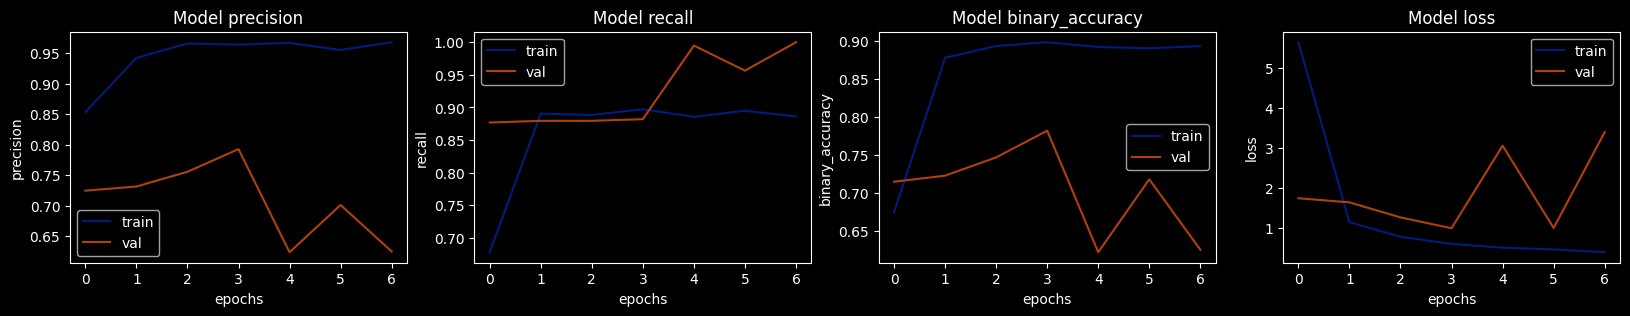

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [24]:
model = tf.keras.models.load_model('./models/xray_model.h5')
model.evaluate(testdataset , return_dict = True)

2025-12-29 18:21:47.038505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 472 of -2
2025-12-29 18:21:47.089592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 364ms/step - binary_accuracy: 0.7797 - loss: 1.0149 - precision: 0.7969 - recall: 0.8747


2025-12-29 18:21:48.393864: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-29 18:21:48.393884: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11522251978316460306
2025-12-29 18:21:48.393888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-12-29 18:21:48.393897: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7869210055933403791
2025-12-29 18:21:48.393901: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10028893520723654009
2025-12-29 18:21:48.393904: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4506497013464983205
2025-12-2

{'binary_accuracy': 0.7820512652397156,
 'loss': 0.9912183880805969,
 'precision': 0.7926267385482788,
 'recall': 0.8820512890815735}

2025-12-29 18:35:51.642597: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 472 of -2
2025-12-29 18:35:51.699206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 200ms/step


2025-12-29 18:35:52.198174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1: % of NORMAL:[3.4093857e-05]
1: % of PNEUMONIA:[0.9999659]
2: % of NORMAL:[0.9970796]
2: % of PNEUMONIA:[0.0029204]


2025-12-29 18:36:03.577799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 472 of -2
2025-12-29 18:36:03.623922: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-12-29 18:36:03.691592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


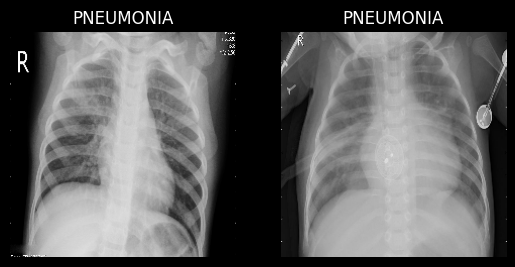

In [36]:
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]
predictions = model.predict(testdataset.take(2))
for i , (image , label) in enumerate(testdataset.take(2)):
    prediction = predictions[i]
    scores = [1 - prediction , prediction]
    for score , lab in zip(scores , CLASS_NAMES):
        print(f"{i+1}: % of {lab}:{score}")
    plt.subplot(1 , 2, i + 1)
    plt.imshow(image[i] / 255.0)
    plt.title(CLASS_NAMES[label[i]])
    plt.axis('off')

## confusion matrix


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

2025-12-29 19:17:22.736808: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 472 of -2
2025-12-29 19:17:22.800844: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


2025-12-29 19:17:23.566368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


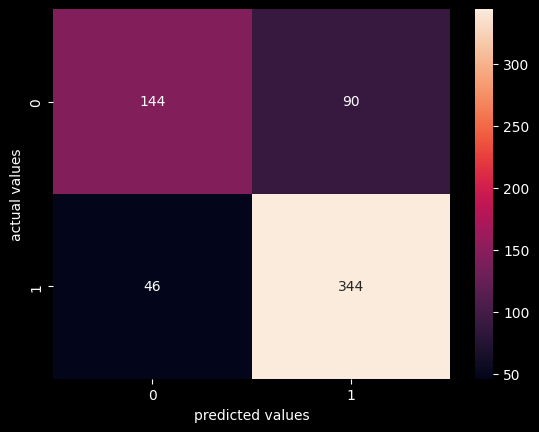

In [97]:
label_list = []
prediction_list = []

for image , label in testdataset.take(20):
    prediction = model.predict(image).squeeze()

    prediction = (prediction > 0.5).astype(int)
    prediction_list.extend(prediction.tolist())
    # print(label)
    label_list.extend(label.numpy().tolist())


cmat = tf.math.confusion_matrix(label_list , prediction_list)
ax = sns.heatmap(cmat , annot = True , fmt = 'g')
ax.set(xlabel = 'predicted values' , ylabel = 'actual values')
plt.show()

In [90]:
len(prediction_list) == len(label_list)

True

[[0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
